In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import os
os.chdir("/content/gdrive/My Drive/CS_543_final")

In [3]:
ls

data/


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [22]:
os.listdir(".")

['data', 'model.tar', 'output']

In [0]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm


In [0]:
train_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

In [8]:
from PIL import Image
class BridgeDataset(torch.utils.data.Dataset):

    def __init__(self, im_dir='./data/images', lb_dir = './data/labels', dups=10, transform=None):
        self.transform = transform
        self.im_dir = im_dir
        self.lb_dir = lb_dir
        self.dups = dups
        self.samples = []
        print("loading images")
        for i in tqdm(range(15)):
            im_path = os.path.join(self.im_dir, 'im{}.jpg'.format(i+1))
            lb_path = os.path.join(self.lb_dir, 'ann{}.jpg'.format(i+1))
        
            im = imageio.imread(im_path)
            lb = imageio.imread(lb_path).mean(2)/255
            im = Image.fromarray(im)
            lb = Image.fromarray(lb)
            sample = (im, lb)
            self.samples.append(sample)
    def __len__(self):
        '''
        We have 15 images
        '''
        return 15*self.dups

    def __getitem__(self, idx):
        idx = idx % 10
        im, lb =  self.samples[idx]
        if self.transform:
            im = self.transform(im)
            lb = self.transform(lb)
        sample = (im, lb)
        return sample

dataset = BridgeDataset(transform=train_transform)

loading images


In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=32)

In [10]:
import torch as torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

def get_model():

    model = models.vgg16(pretrained=True)
    model._modules['features'] = model._modules['features'][:23] 
    model = model._modules['features']

    model.add_module("pool5", torch.nn.MaxPool2d(kernel_size=3, stride=1,padding=1))

    model.add_module("fc6", torch.nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=4, dilation=4))

    model.add_module("fc6-bn", torch.nn.BatchNorm2d(1024))
    model.add_module("fc6-relu", torch.nn.ReLU())
    
    model.add_module("fc7", torch.nn.Conv2d(1024, 128, kernel_size=3, stride=1, padding=0))
    model.add_module("fc7-bn", torch.nn.BatchNorm2d(128))
    model.add_module("fc7-relu", torch.nn.ReLU())
    
    model.add_module("fc8", torch.nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=0))

    model.add_module("upsample", torch.nn.Upsample((256, 256), mode='bilinear'))
    model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

    return model
load = True
   
model = get_model().cuda()
if load:
    model.load_state_dict(torch.load('./model.tar'), strict=False)
summary(model, (3, 256, 256))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:20<00:00, 26617174.43it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:

import torch.optim as optim
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([0.1,10]).cuda())
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


In [0]:
from torch.autograd import Variable
EPOCHS = 20
train_loss_over_epochs = []
val_accuracy_over_epochs = []


In [13]:
with tqdm(range(EPOCHS)) as epochs:
    for epoch in epochs:
        running_loss = 0.0
        for i, data in tqdm(enumerate(dataloader, 0), leave=False):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.long().cuda()

            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            del labels
            del inputs

            running_loss += loss.item()

        running_loss/=len(dataloader)
        
        print('[{}] loss: {:.3f}'.format(epoch + 1, running_loss))

        train_loss_over_epochs.append(running_loss)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[1] loss: 0.639


[2] loss: 0.382


[3] loss: 0.278


[4] loss: 0.250


[5] loss: 0.238


[6] loss: 0.229


[7] loss: 0.221


[8] loss: 0.213


[9] loss: 0.207


[10] loss: 0.200


[11] loss: 0.195


[12] loss: 0.188


[13] loss: 0.184


[14] loss: 0.180


[15] loss: 0.177


[16] loss: 0.170


[17] loss: 0.167


[18] loss: 0.163


[19] loss: 0.160


[20] loss: 0.157



In [0]:
torch.save(model.state_dict(), "./model.tar")

In [0]:
# taken from http://ronny.rest/tutorials/module/localization_001/iou/

def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [0]:
def get_seg(i):
    sample = dataset.samples[i][0]
    im = transforms.Resize((256, 256))(sample)
    sample = transforms.ToTensor()(im).cuda().unsqueeze(0)
    out = model(sample)
    outim = out.squeeze().cpu().detach().numpy().transpose(1,2,0)
    probmap = np.exp(outim)
    seg = probmap.argmax(2)
    return im, probmap, seg

def get_bounds(seg, threshold=0.1):
    rows = seg.mean(1)
    cols = seg.mean(0)
    bridge_cols = np.arange(len(cols))[(cols > threshold)]
    start_col, end_col = bridge_cols[0], bridge_cols[-1]
    bridge_rows = np.arange(len(rows))[(rows > threshold)]
    start_row, end_row = bridge_rows[0], bridge_rows[-1]
    return ((start_row, end_row), (start_col, end_col))

def get_label(i):
    label = dataset.samples[i][1]
    im = transforms.Resize((256, 256))(label)
    label = transforms.ToTensor()(im).cuda().unsqueeze(0)
    return label.squeeze().cpu().detach().numpy()

RoIs = []
IoUs = []
for i in range(10, 15):
    im, probmap, seg = get_seg(i)
    label = get_label(i)
    ((start_row, end_row), (start_col, end_col)) = get_bounds(seg, threshold=0.2)
    
    ((start_row_lb, end_row_lb), (start_col_lb, end_col_lb)) = get_bounds(label, threshold=0.001)
    im_area = seg.shape[0]*seg.shape[1]
    crop_area = (end_col - start_col) * (end_row - start_row)
    RoIs.append(crop_area/im_area)
    a = [start_col, start_row, end_col, end_row]
    b = [start_col_lb, start_row_lb, end_col_lb, end_row_lb]
    IoU = get_iou(a, b)
    IoUs.append(IoU)
    print("Cropped area: {}, Original area: {}, Ratio: {}, RoIs: {:.1%}, IoU: {}" .format(crop_area, im_area, crop_area/im_area, 1 - crop_area/im_area, IoU))
    
#     plt.figure(figsize=(10,20))
#     plt.subplot(421)
#     plt.title("Original")
#     plt.imshow(im)
#     plt.axis('off')
#     plt.subplot(422)
#     plt.title("Ground Truth")
#     plt.imshow(label, cmap='gray', vmin=0, vmax=1)
#     plt.axis('off')

#     plt.subplot(423)
#     plt.title("Probmap (Background)")
#     plt.imshow(probmap[:,:,0], cmap='gray', vmin=0, vmax=1)
#     plt.axis('off')
#     plt.subplot(424)
#     plt.title("Probmap (Bridge)")
#     plt.imshow(probmap[:,:,1], cmap='gray', vmin=0, vmax=1)
#     plt.axis('off')
    
#     plt.subplot(425)
#     plt.title("Ground Truth")
#     plt.imshow(label, cmap='gray', vmin=0, vmax=1)
#     plt.axis('off')
#     plt.subplot(426)
#     plt.title("Segmentation")
#     plt.imshow(seg, cmap='gray', vmin=0, vmax=1)
#     plt.axis('off')
    
#     plt.subplot(427)
#     plt.title("Ground Truth Crop")
#     plt.imshow(np.array(im)[start_row_lb: end_row_lb, start_col_lb:end_col_lb])
#     plt.axis('off')
#     plt.subplot(428)
#     plt.title("Auto Crop")
#     plt.imshow(np.array(im)[start_row: end_row, start_col:end_col])
#     plt.axis('off')
    
    plt.imsave("./output/RoI-{}.png".format(i), np.array(im)[start_row: end_row, start_col:end_col])
#     plt.plot()
np.array(RoIs).mean(), np.array(IoUs).mean()


In [17]:
(IoUs[0] + IoUs[1] + IoUs[3] + IoUs[4])/4

0.797331858820294

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


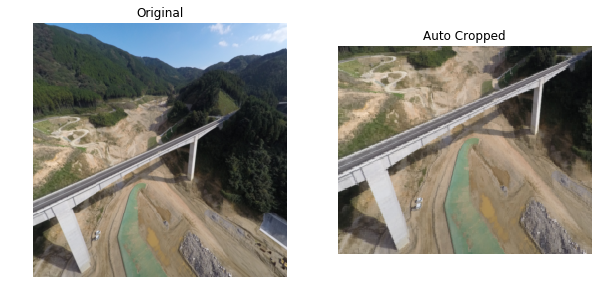

In [18]:

im, probmap, seg = get_seg(10)
((start_row, end_row), (start_col, end_col)) = get_bounds(seg, threshold=0.1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Original")
plt.imshow(im)
plt.axis('off')
plt.subplot(122)
plt.title("Auto Cropped")
plt.imshow(seg, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.imshow(np.array(im)[start_row: end_row, start_col:end_col])

'00000011.jpg'

In [45]:
def get_seg(i):
    im_path = os.path.join('./reference', str(i).zfill(8) + '.jpg')
    full_im = Image.fromarray(imageio.imread(im_path))
    im = transforms.Resize((256, 256))(full_im)
    sample = transforms.ToTensor()(im).cuda().unsqueeze(0)
    out = model(sample)
    outim = out.squeeze().cpu().detach().numpy().transpose(1,2,0)
    probmap = np.exp(outim)
    seg = probmap.argmax(2)
    return im, probmap, seg, full_im

def get_bounds(seg, threshold=0.1):
    rows = seg.mean(1)
    cols = seg.mean(0)
    bridge_cols = np.arange(len(cols))[(cols > threshold)]
    start_col, end_col = bridge_cols[0], bridge_cols[-1]
    bridge_rows = np.arange(len(rows))[(rows > threshold)]
    start_row, end_row = bridge_rows[0], bridge_rows[-1]
    return ((start_row, end_row), (start_col, end_col))

RoIs = []
RoIH = []
RoIW = []
IoUs = []
for i in tqdm(range(100)):
    im, probmap, seg, full_im = get_seg(i)
    ((start_row, end_row), (start_col, end_col)) = get_bounds(seg, threshold=0.2)
    
#     ((start_row_lb, end_row_lb), (start_col_lb, end_col_lb)) = get_bounds(label, threshold=0.001)
    im_area = seg.shape[0]*seg.shape[1]
    RoIW.append((end_col-start_col)/256)
    RoIH.append((end_row-start_row)/256)
    crop_area = (end_col - start_col) * (end_row - start_row)
    RoIs.append(crop_area/im_area)
#     a = [start_col, start_row, end_col, end_row]
#     b = [start_col_lb, start_row_lb, end_col_lb, end_row_lb]
#     IoU = get_iou(a, b)
#     IoUs.append(IoU)
    full_im = np.array(full_im)
#     plt.imsave( os.path.join('./output', str(i).zfill(8) + '-RoI.jpg'), full_im[int(start_row*3598/256):int(end_row*3598/256), int(start_col*4797/256):int(end_col*4797/256)])
np.array(RoIs).mean()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.47667770385742186

In [51]:
1-np.array(RoIH).mean(), 1-np.array(RoIW).mean()
np.array(RoIH).mean(), np.array(RoIW).mean()

(0.594765625, 0.8169140625)

In [48]:
np.array(RoIH).mean() * np.array(RoIW).mean()

0.4858724029541015

In [52]:
(1-0.3501),(1-0.3256)


(0.6498999999999999, 0.6744)

In [54]:
96.3/137.4, 99.4/137.4


(0.7008733624454148, 0.7234352256186317)